In [1]:
import cartopy.crs as ccrs
import intake
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import numpy as np
import xarray as xr
from tqdm.autonotebook import tqdm
import pyremo as pr
import cordex as cx
import cmaps
import glob
import datetime
from REMO2020_mod import modelclass, season_mean, open_mfdataset, open_mfdataset_calipso

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernel2023/share/proj failed
/tmp/ipykernel_90019/4028671629.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# give figure path
figpath = './figures/'

In [3]:
# REMO, calipso and era5 datapaths
rdata = './data_in/model_data/calipso/'
caldata = './data_in/CALIPSO-GOCCP/'
e5data = './data_in/ERA5/'

In [4]:
# Which calipso version to use
# 1: 1x1 CFMIP1
# 2: 2x2 CFMIP2
CalVer = 2
#
CalRes = str(CalVer)+"x"+str(CalVer)
CalMIP = "CFMIP"+str(CalVer)

In [5]:
# Open calipso data
calfilenames = glob.glob(caldata+CalRes+"/3D_CloudFraction330m_*_avg_"+CalMIP+"_sat_3.1.2.nc")
calfilenames.sort()

In [6]:
# create time dimension values (month: search string between year and '.nc')
timevals = [datetime.datetime(int(fname.split("CloudFraction330m_")[1].split('_avg_')[0][0:4]),int(fname.split("CloudFraction330m_")[1].split('_avg_')[0][4:6]),15) for fname in calfilenames]

In [7]:
# open calipso data
dscal = open_mfdataset_calipso(calfilenames, parallel=False, chunks='auto')

In [8]:
# add time coordinate values
dscal["time"] = timevals

In [9]:
# Define year for CALIPSO to be plotted (data from 6-2006 to 12-2019)
calyears = [2006,2020]

In [10]:
# Define years for ERA5 (data from 01-2001 to 12-2010)
era5years = [2001,2010]

In [11]:
# Define years for REMO (data from 01-2001 to 12-2010)
remoyears = [2001,2010]

In [12]:
# Open ERA5 files
era5filenames = glob.glob(e5data+"Cloud_fraction/ERA5p1_CALIPSO-GOCCP_Cloud_fraction_*.nc")
era5filenames.sort()

In [13]:
# open ERA5
dsera5 = pr.parse_dates(open_mfdataset(era5filenames, parallel=False, chunks='auto'))

In [14]:
# define the runs to be plotted
modelruns =[] # init
modelruns.append(modelclass("056524","REMO2015",False,"var162"))
modelruns.append(modelclass("036030","REMO2020$_{27}$",True,"ACLC"))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True,"ACLC"))

In [15]:
# Set halo zone length (will be cutted out)
halo = 8

In [16]:
# open model data
for obj in modelruns:
    dstmp = pr.parse_dates(xr.open_dataset(rdata+obj.userexp+"_calipso_hlevs_2001-2010.nc"))
    obj.vardiff = season_mean(dstmp.sel(time=slice(str(remoyears[0]), str(remoyears[1])))[[obj.varname]])
    obj.vardiff = obj.vardiff.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1)).compute()
    if(obj.r2020file):
        # get pole
        pole = (dstmp.rotated_latitude_longitude.grid_north_pole_longitude,dstmp.rotated_latitude_longitude.grid_north_pole_latitude)
        # calculate absolute mins/maxs for real coorindates (we use these to cut the global data)
        min_lon = np.min(obj.vardiff.lon.values)
        max_lon = np.max(obj.vardiff.lon.values)
        min_lat = np.min(obj.vardiff.lat.values)
        max_lat = np.max(obj.vardiff.lat.values)
        # calculate average latitudes for plotting
        avg_lats = obj.vardiff.lat.mean(dim="rlon")

In [17]:
# change the rotated coordinates and make zonal mean
for obj in modelruns:
    obj.vardiff = obj.vardiff.mean(dim=("rlon"))
    obj.vardiff = obj.vardiff.rename({"rlat": "latitude"})
    obj.vardiff["latitude"] = avg_lats

In [18]:
# make zonal mean for calipso
dscal_lonmean = season_mean(dscal.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon)).sel(time=slice(str(calyears[0]), str(calyears[1]))).mean(dim=("longitude")))

In [19]:
# make zonal mean for era5
dsera5_lonmean = season_mean(dsera5.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon)).sel(time=slice(str(era5years[0]), str(era5years[1]))).mean(dim=("lon")))

In [20]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

/tmp/ipykernel_90019/3510147542.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tmp = mpl.cm.get_cmap("Blues",256).copy()


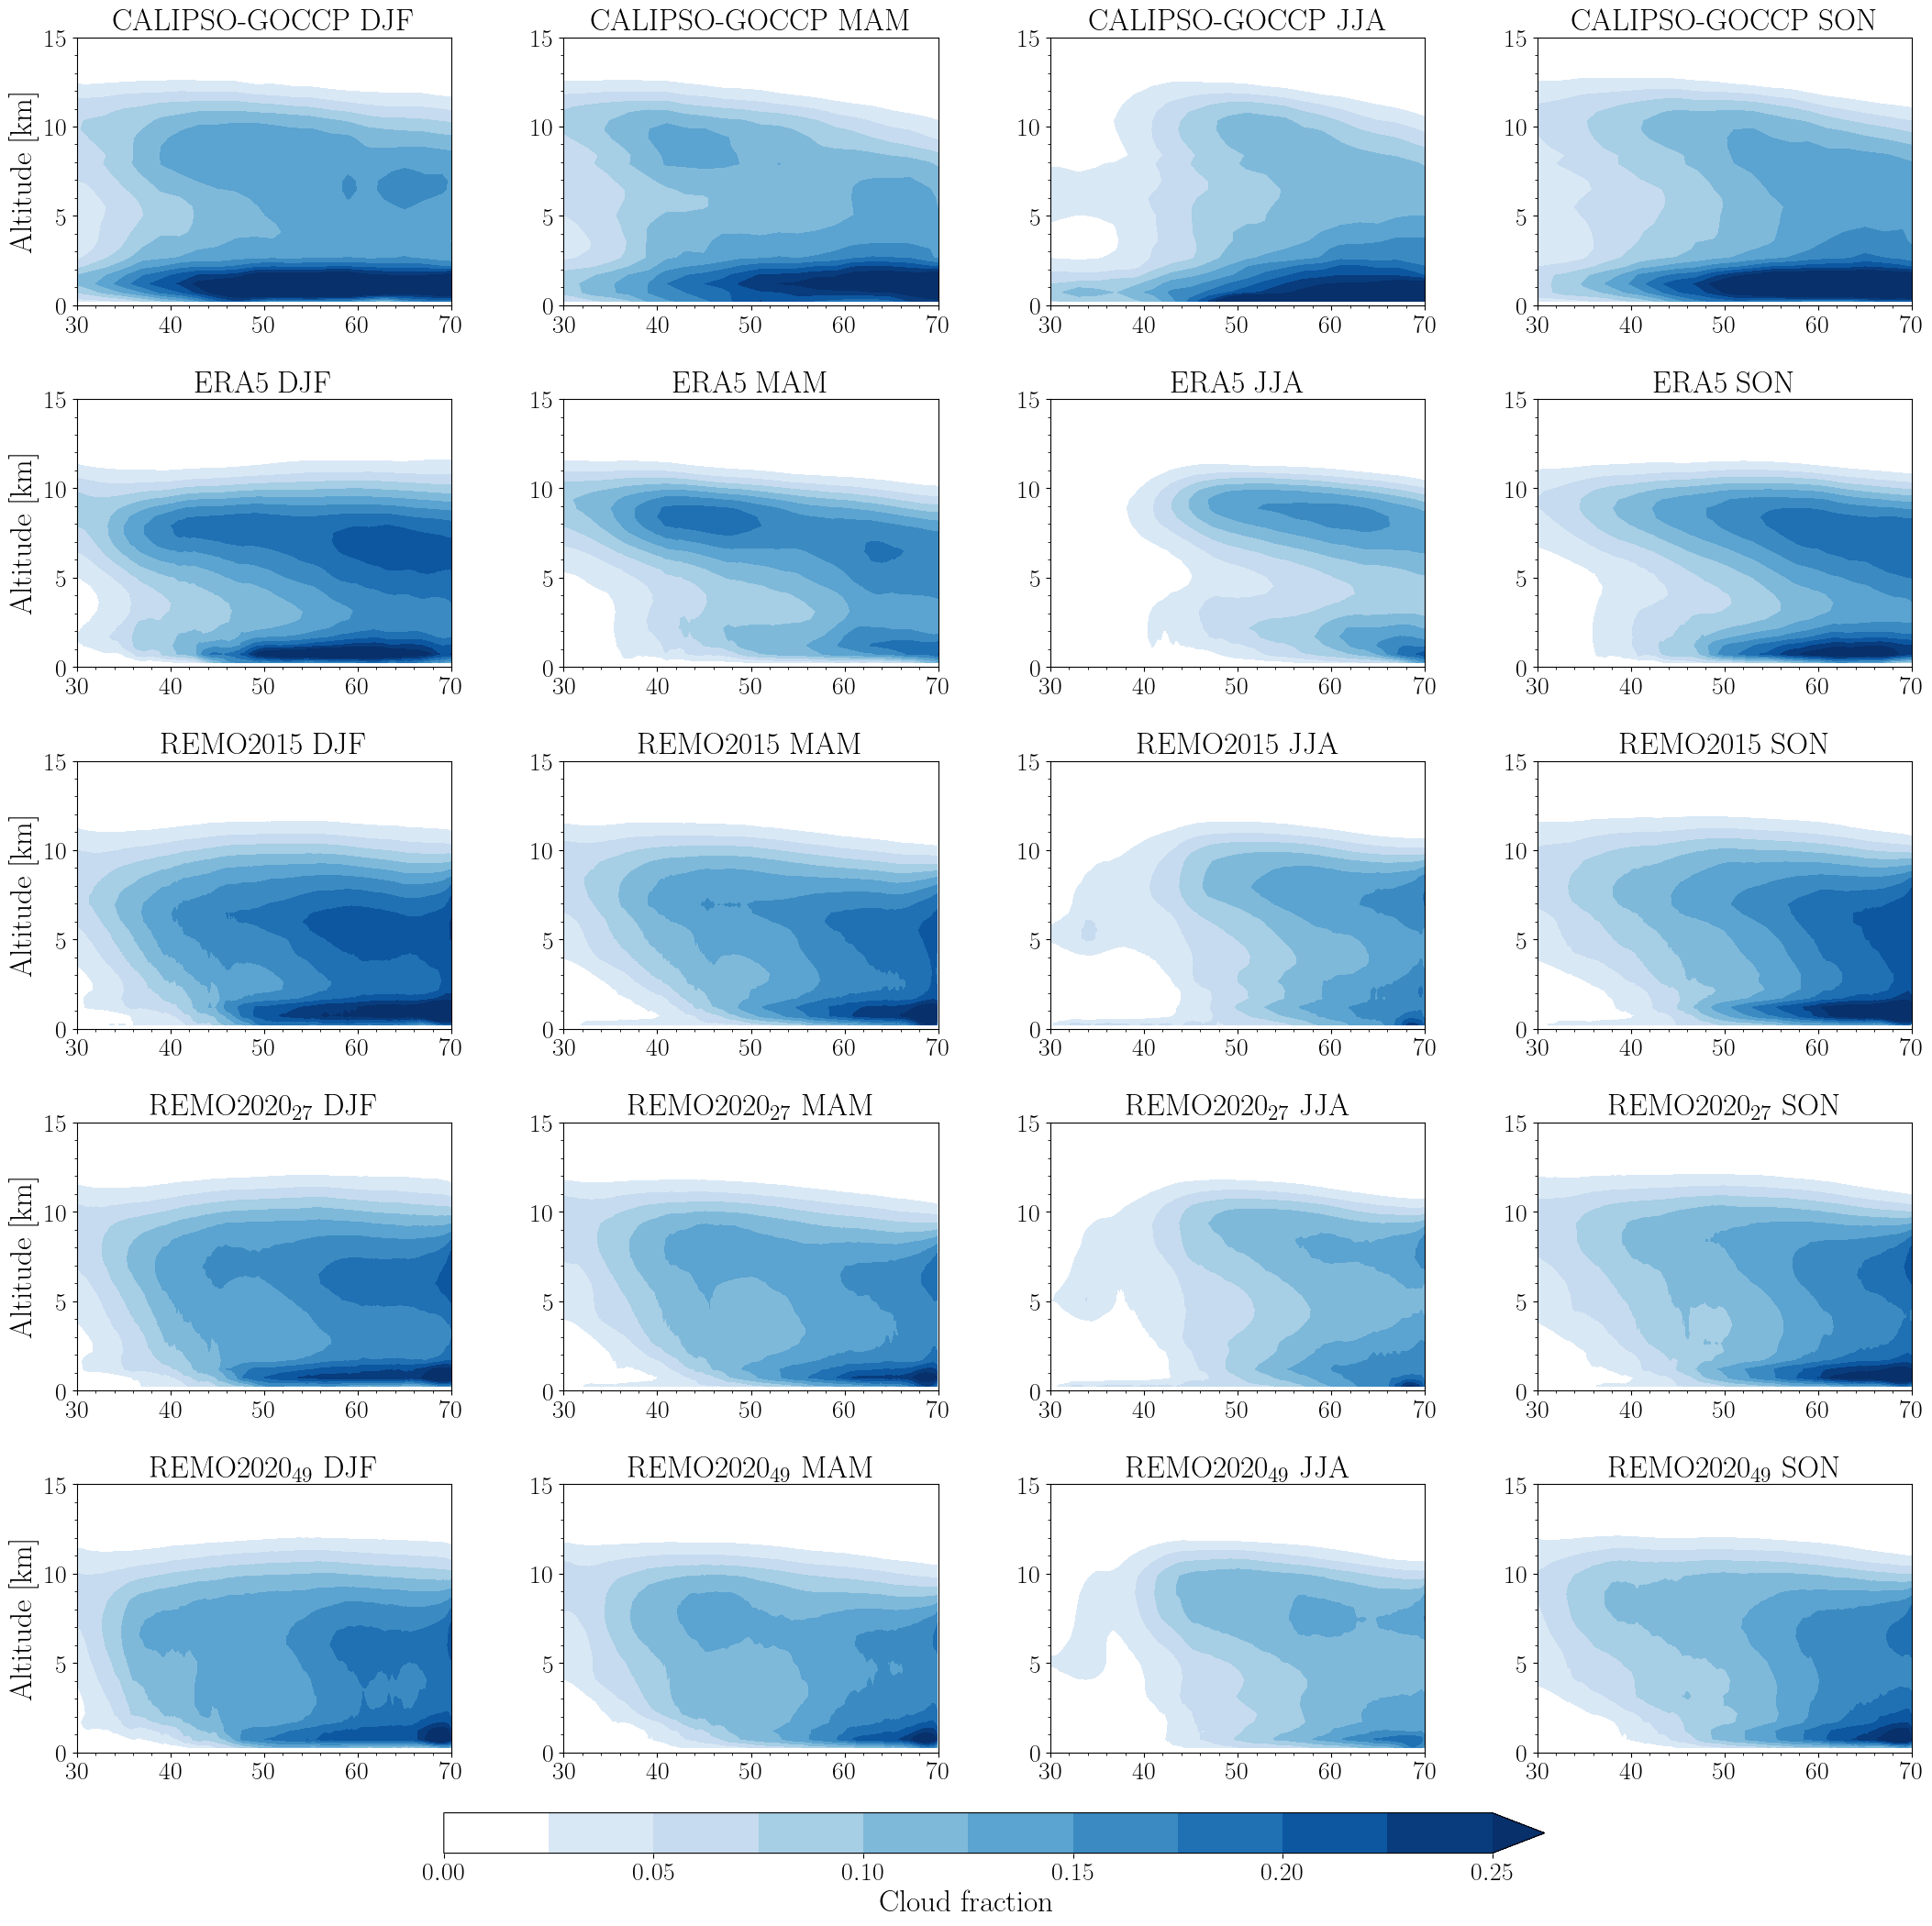

In [21]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20, (len(modelruns)+1)*5.5)
plt.rcParams["figure.subplot.hspace"] = 0.35 # the amount of height reserved for white space between subplots
plt.rcParams["figure.subplot.wspace"] = 0.3 # the amount of width reserved for blank space between subplots
plt.rcParams["axes.titlesize"] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 24

gs = gridspec.GridSpec(len(modelruns)+2,4)                     

fig=plt.figure()
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=1.0, left=0, right=1.0)

# xlim, xticks and xticklabels
xlimmi = [30,70]
xtickki = [35,45,55,65]
xtickkilab = [str(ii)+"N" for ii in xtickki]

# ylim
ylimmi = [0,15]

# number of clorbar bins
nbins=10

# contour levels
levels = np.linspace(0.0, 0.25, nbins+1)

# cut limit for white color (everything below this)
# If levels[1] is used, then the first bin is white
ccut = levels[1]

# create custom colormap
cmap_tmp = mpl.cm.get_cmap("Blues",256).copy()
newcolors = cmap_tmp(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[:int(ccut/levels[-1]*256), :] = white
cmappi = ListedColormap(newcolors)


sb=[]
ii=-1
jj = 0
# CALIPSO-GOCCP
for seas in seasons:
    ii=ii+1
    jj=jj+1
    sb = np.append(sb,plt.subplot(gs[ii]))
    # contour plot
    cp = plt.contourf(dscal_lonmean.sel(season=seas).latitude.values,dscal_lonmean.sel(season=seas).alt_mid.values,dscal_lonmean.sel(season=seas).clcalipso, levels=levels, cmap=cmappi, extend='max')
    # Get axes
    ax = plt.gca()
    # Title
    plt.title("CALIPSO-GOCCP "+seas)
    # xlimit
    plt.xlim(xlimmi)
    # set minor ticks on
    plt.minorticks_on()
    #xlabels
    #plt.xticks(xtickki)
    #ax.set_xticklabels(xtickkilab)
    # set y-label
    if(jj==1):
        plt.ylabel("Altitude [km]")
    # ylimit
    plt.ylim(ylimmi)
        
jj = 0
# ERA5
for seas in seasons:
    ii=ii+1
    jj=jj+1
    sb = np.append(sb,plt.subplot(gs[ii]))
    # contour plot (note unit change from m to km)
    cp = plt.contourf(dsera5_lonmean.sel(season=seas).lat.values,dsera5_lonmean.sel(season=seas).height.values/1000.0,dsera5_lonmean.sel(season=seas).cc.transpose(), levels=levels, cmap=cmappi, extend='max')
    # Get axes
    ax = plt.gca()
    # Title
    plt.title("ERA5 "+seas)
    # xlimit
    plt.xlim(xlimmi)
    # set minor ticks on
    plt.minorticks_on()
    # set y-label
    if(jj==1):
        plt.ylabel("Altitude [km]")
    # ylimit
    plt.ylim(ylimmi)

# model data
for obj in modelruns:
    jj = 0
    for seas in seasons:
        ii=ii+1
        jj=jj+1
        sb = np.append(sb,plt.subplot(gs[ii]))
        # contour plot (note unit change from m to km)
        cp = plt.contourf(obj.vardiff.sel(season=seas).latitude.values,obj.vardiff.sel(season=seas).height.values/1000.0,obj.vardiff.sel(season=seas)[obj.varname], levels=levels, cmap=cmappi, extend='max')
        # Get axes
        ax = plt.gca()
        # Title
        plt.title(obj.runame+" "+seas)
        # xlimit
        plt.xlim(xlimmi)
        # set minor ticks on
        plt.minorticks_on()
        # set y-label
        if(jj==1):
            plt.ylabel("Altitude [km]")
        # ylimit
        plt.ylim(ylimmi)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
    
# Draw the colorbar
cbar=fig.colorbar(cp, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Cloud fraction', fontsize=24)
# Save figure
figname = 'CALIPSO_GOCCP_'+CalMIP+"_"+str(calyears[0])+'-'+str(calyears[1])+'_ERA5p1_'+str(era5years[0])+'-'+str(era5years[1])+'_REMO_'+str(remoyears[0])+'-'+str(remoyears[1])+'.png'
plt.savefig(figpath+figname,format="png",bbox_inches='tight', pad_inches=0)